In [1]:
import yfinance as yf
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
def get_prices(ticker, start="2023-01-01", end="2025-01-01"):
    data = yf.download(ticker, start=start, end=end, progress=False)
    if data.empty:
        raise ValueError(f"No data returned for {ticker}")
    if "Adj Close" in data.columns:
        return data["Adj Close"]
    else:
        print(f"⚠️ 'Adj Close' not found for {ticker}, using 'Close' instead")
        return data["Close"]

# Fetch separately
ko = get_prices("KO")
pep = get_prices("PEP")

# Merge into one DataFrame
data = pd.concat([ko, pep], axis=1)
data.columns = ["KO", "PEP"]

print(data.head())

⚠️ 'Adj Close' not found for KO, using 'Close' instead
⚠️ 'Adj Close' not found for PEP, using 'Close' instead
                   KO         PEP
Date                             
2023-01-03  57.923161  164.087448
2023-01-04  57.895554  163.685028
2023-01-05  57.233047  161.974777
2023-01-06  58.337227  165.633148
2023-01-09  57.610302  164.014267


C:\Users\jmlud\AppData\Local\Temp\ipykernel_12152\289051401.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, progress=False)
C:\Users\jmlud\AppData\Local\Temp\ipykernel_12152\289051401.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, progress=False)


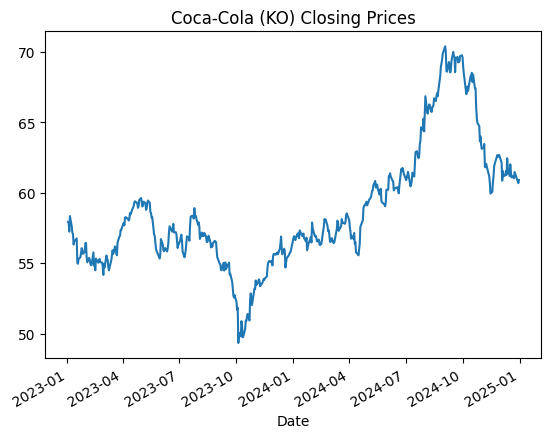

In [21]:
ko_data = yf.Ticker('KO').history(interval='1d', start='2023-01-01', end='2025-01-01')
ko_data.head()
# plot the closing prices
ko_data['Close'].plot(title='Coca-Cola (KO) Closing Prices')
plt.show()

In [16]:
# compute the rolling mean and std deviation for each asset
window = 30
data['KO_Mean'] = data['KO'].rolling(window=window).mean()
data['KO_Std'] = data['KO'].rolling(window=window).std()
data['PEP_Mean'] = data['PEP'].rolling(window=window).mean()
data['PEP_Std'] = data['PEP'].rolling(window=window).std()


C:\Users\jmlud\AppData\Local\Temp\ipykernel_12152\1951911594.py:25: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['KO_Position'] = data['KO_Position'].replace(to_replace=0, method='ffill')
C:\Users\jmlud\AppData\Local\Temp\ipykernel_12152\1951911594.py:26: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['PEP_Position'] = data['PEP_Position'].replace(to_replace=0, method='ffill')
C:\Users\jmlud\AppData\Local\Temp\ipykernel_12152\1951911594.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or 

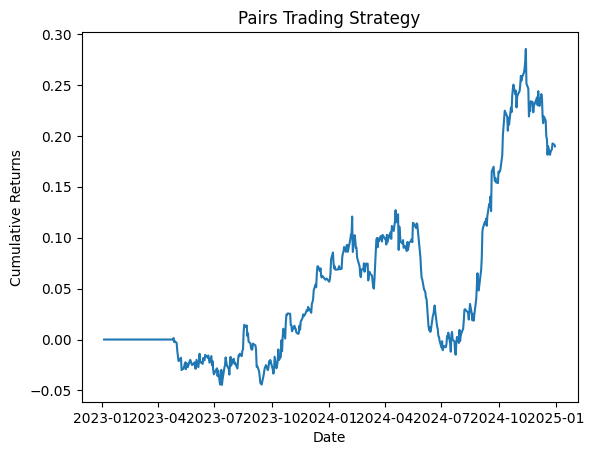

In [17]:
# compute the z scores for each asset
data['KO_Z'] = (data['KO'] - data['KO_Mean']) / data['KO_Std']
data['PEP_Z'] = (data['PEP'] - data['PEP_Mean']) / data['PEP_Std']

# compute the spread
data['Spread'] = data['KO_Z'] - data['PEP_Z']

# compute the rolling mean and std deviation of the spread
data['Spread_Mean'] = data['Spread'].rolling(window=window).mean()
data['Spread_Std'] = data['Spread'].rolling(window=window).std()

# compute the upper and lower bands for the spread
data['Upper_Band'] = data['Spread_Mean'] + 2* data['Spread_Std']
data['Lower_Band'] = data['Spread_Mean'] - 2* data['Spread_Std']

# calculate the entry and exit signals
long_signal = (data['Spread'] < data['Lower_Band'])
short_signal = (data['Spread'] > data['Upper_Band'])

# compute positions for each asset
data['KO_Position'] = long_signal.astype(int) - short_signal.astype(int)
data['PEP_Position'] = -long_signal.astype(int) + short_signal.astype(int)

# extend positions forward to simulate holding
data['KO_Position'] = data['KO_Position'].replace(to_replace=0, method='ffill')
data['PEP_Position'] = data['PEP_Position'].replace(to_replace=0, method='ffill')
data['KO_Position'].fillna(0, inplace=True)
data['PEP_Position'].fillna(0, inplace=True)

# compute the portfolio logarithmic returns
asset1_returns = data['KO'].pct_change()
asset2_returns = data['PEP'].pct_change()
portfolio_returns = (data['KO_Position'].shift(1) * asset1_returns) + (data['PEP_Position'].shift(1) * asset2_returns)

# compute the total logarithmic returns and plot the results
data['Portfolio_Returns'] = portfolio_returns
data['Cumulative_Returns'] = (1 + data['Portfolio_Returns']).cumprod() - 1
plt.plot(data['Cumulative_Returns'])
plt.title("Pairs Trading Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.show()




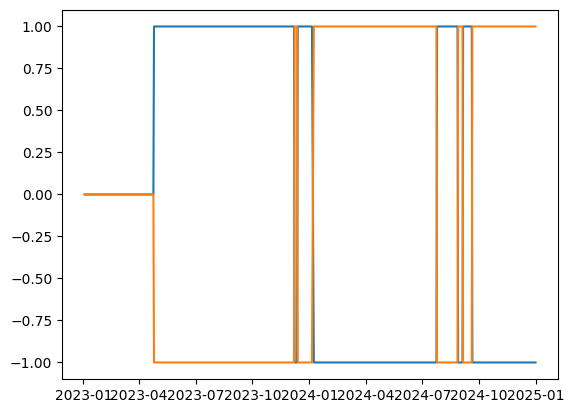

In [18]:
# plot the trading signals
plt.plot(data['KO_Position'])
plt.plot(data['PEP_Position'])

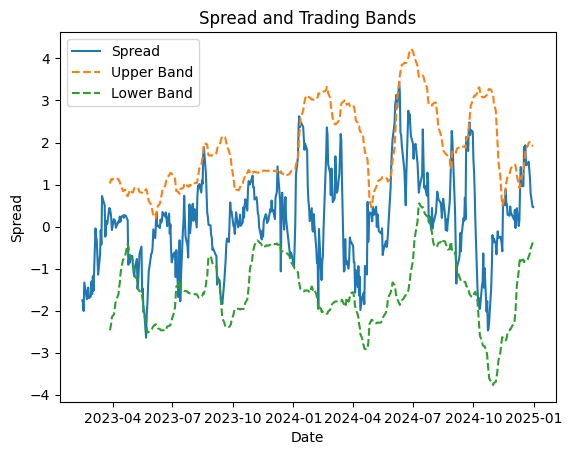

In [19]:
# what should the trading singal be? Plot spread vs UB/LB
plt.plot(data['Spread'], label='Spread')
plt.plot(data['Upper_Band'], label='Upper Band', linestyle='--')
plt.plot(data['Lower_Band'], label='Lower Band', linestyle='--')
plt.legend()
plt.title("Spread and Trading Bands")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.show()

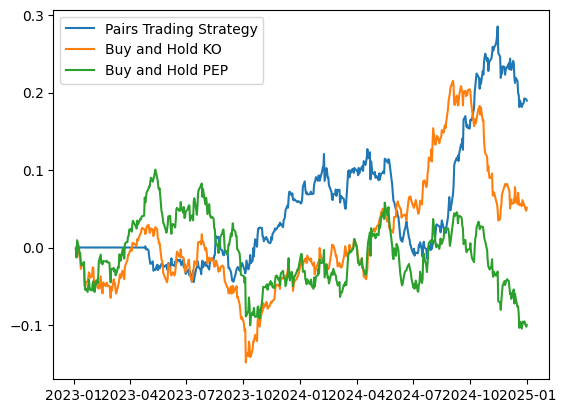

In [20]:
# compare strategy to buy and hold
plt.plot((1 + data['Portfolio_Returns']).cumprod() - 1, label='Pairs Trading Strategy')
plt.plot((1 + asset1_returns).cumprod() - 1, label='Buy and Hold KO')
plt.plot((1 + asset2_returns).cumprod() - 1, label='Buy and Hold PEP')
plt.legend()

In [4]:
price_array = np.array([2,4,2])
price_array = price_array - np.mean(price_array)
print(price_array)

[-0.66666667  1.33333333 -0.66666667]
